# COMPSCI 690V - Midterm - Text analysis and visualization

### Team members: 
1. Chao-Ching Chiang
2. Bailin Wang
3. Jin Zhang

### Datasets
* USA Geolocated Twitter dataset: http://followthehashtag.com/datasets/free-twitter-dataset-usa-200000-free-usa-tweets/

In [1]:
import re
import numpy as np
import pandas as pd
from bokeh.io import output_notebook, push_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from utils import extract_hashtags, count_cooccurence
from cluster import preprocess

output_notebook()

Loading BokehJS ...

## Objective 1 - Analyze hashtags in tweets

* package sklearn is required.
* package networkx is required.

Out first goal it to analyze hashtags in tweets and rank them using different metrics.

In [2]:
fpath = './data/USA-Geolocated-tweets/dashboard_x_usa_x_filter_nativeretweets.xlsx'
df = pd.read_excel(fpath, sheetname='Stream')
tweets = df['Tweet content']
print('Number of tweets: {}'.format(len(tweets)))

Number of tweets: 204820


### Preprocessing
* Extract hashtags based on regular expression.
* We only care about important hashtags. Thus, we set a threshold for the count of hashtags so that we can observe the most influential ones.
* Then, we construct a weighted, undirected graph based on their co-occurence in the tweets.

In [3]:
# Set the threshold for the hashtags. We only extract hashtags whose count is higher than the threshold. 
THRESHOLD = 700
PLOT_PARAM = {'plot_height': 400, 'plot_width': 400, 'toolbar_location': None}

# Extract hashtags from tweets and count their co-occurence
id2word, word2id = extract_hashtags(tweets, THRESHOLD)
co_occurence = count_cooccurence(tweets, word2id)
words = list(word2id.keys())
nWords = len(words)

# Set up position for the nodes
theta = 2 * np.pi / nWords
circ = [i * theta for i in range(nWords)]
coord_x = [np.cos(i) for i in circ]
coord_y = [np.sin(i) for i in circ]

# Set up data source
s1 = ColumnDataSource(data=dict(x=coord_x, y=coord_y, hashtag=words))

# Plot the graph
hover = HoverTool(tooltips=[('Hashtag', '@hashtag')])
p1 = figure(title="Hashtag co-occurence graph", tools=[hover], **PLOT_PARAM)
for (n1, n2), count in co_occurence.items():
    n1_x, n1_y = coord_x[n1], coord_y[n1]
    n2_x, n2_y = coord_x[n2], coord_y[n2]
    p1.line([n1_x, n2_x], [n1_y, n2_y], line_color="#949494")
scatter = p1.circle('x', 'y', source=s1, size=20)
hover.renderers.append(scatter)

# Set up figure parameters
p1.grid.visible = False
p1.axis.visible = False
p1.outline_line_color = None
p1.title.text_font_size = '16px'

show(p1)

After we construct the co-occurenece graph, we apply several network analysis metrics to evaluate the importance of these hashtags:
* Weighted PageRank
* Degree centrality
* Closeness centrality
* Betweenness centrality

### Clustering
These scores were treated as the features of the hashtags. Then, we use K-means and SpectralClustering algorithm to cluster the hashtags. We build an interactive scatter plot to visualize our results.

Interactive version of it can be see running:

        bokeh serve --show hashtag.py
        
(ps. Note that it might take a few minutes to read in the dataset.)

## Objective 2 - Analyze text in tweets

* package wordcloud is required. 

Firstly, we use word cloud to visualize some most common words in tweets like "hiring", "jobs" etc.

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

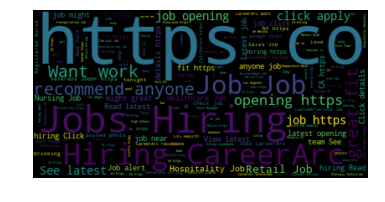

In [5]:
tweet_str = " ".join(tweets)
wordcloud = WordCloud(max_font_size=320).generate(tweet_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Then we try to cluster the tweets using K-means while each tweet is represented according to Bag of Words model.

### Preprocessing
* all numbers are replaced with a speical symbol \$NUM\$
* special character like #, ! are removed
* URL links are removed
* tokenization by space

### Clustering

Each tweet is represented using a word-count vectors.Basically, two cluster algorithms KMeans and Birch are employed. To visualize the high-dimensional vectors, t-sne is used to reduce the dimentionality to 2d so that they can be easily plotted. 

run the following command 

       bokeh serve --show cluster.py
       
***visualization***

Slide bars of adjusting the number of clusters are embedded for interactive visualization.
       
### Observations
* For hashtag analysis, if we set PageRank as the ground truth of the importance of hashtags, we can observe that "job" and "hiring" are the most important hashtags in this dataset. These two hashtags also have high degree centrality, which means that they often come together with other important hashtags.

* However, by observing degree centrality and PageRank, we notice that high degree centrality does not guarantee to have high PageRank score. In the dataset, "Chicage", "Houston", and "LosAngeles" have high degree centrality but low PageRank score. Perhaps these hashtags are just indicating the locations of the users, but not giving imporant information of the tweets.